In [22]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from keras.callbacks import EarlyStopping, ModelCheckpoint

print("Numpy version: ", np.__version__)
print("Pandas version: ", pd.__version__)
print("Sklearn version: ", sk.__version__)
print("TensorFlow version: ", tf.__version__)

Numpy version:  1.26.4
Pandas version:  2.2.3
Sklearn version:  1.6.1
TensorFlow version:  2.18.0


In [12]:
train_df = pd.read_csv('Data/train.csv')
test_df = pd.read_csv('Data/test.csv')

train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [13]:
print(train_df.shape)
print("=" * 50)
print(train_df.info())
print("=" * 50)
print(train_df.isnull().sum())

(7613, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None
id             0
keyword       61
location    2533
text           0
target         0
dtype: int64


## Data Engineering

In [14]:
def preprocessing(df):
    
    df['keyword'] = df['keyword'].fillna('')
    df['location'] = df['location'].fillna('')

    return df

In [15]:
# Preprocess the dataset
train_df = preprocessing(train_df)
X = train_df["text"]
y = train_df["target"]

# Tokenization
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X)
X_seq = tokenizer.texts_to_sequences(X)
maxlen = max(len(seq) for seq in X_seq)
X_pad = pad_sequences(X_seq, maxlen=maxlen)
input_dim = tokenizer.num_words

X_train, X_val, y_train, y_val = train_test_split(X_pad, y, test_size=0.2, random_state=42)

## Model Training

In [26]:
model = Sequential([
    Embedding(input_dim=input_dim, output_dim=128, input_length=maxlen),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.2),
    Bidirectional(LSTM(32)),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.build(input_shape=(None, maxlen))
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 31, 128)        │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 31, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 31, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 780,097 (2.98 MB)

 Trainable params: 780,097 (2.98 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
# Set EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Store best model
checkpoint = ModelCheckpoint("model/biLstm_model.h5", monitor='val_loss', save_best_only=True)


EPOCHS = 50
BATCH_SIZE = 32
history = model.fit(X_train, y_train, 
                    epochs=EPOCHS, 
                    batch_size=BATCH_SIZE,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stop, checkpoint]
                    )

loss, accuracy = model.evaluate(X_val, y_val)
print(f'Validation Accuracy: {accuracy:.4f}')

Epoch 1/50


189/191 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6532 - loss: 0.5982

191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.6544 - loss: 0.5970 - val_accuracy: 0.8063 - val_loss: 0.4389
Epoch 2/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.8625 - loss: 0.3457 - val_accuracy: 0.7965 - val_loss: 0.4762
Epoch 3/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.9060 - loss: 0.2518 - val_accuracy: 0.7899 - val_loss: 0.5035
Epoch 4/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.9243 - loss: 0.2069 - val_accuracy: 0.7492 - val_loss: 0.6228
Epoch 5/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.9507 - loss: 0.1503 - val_accuracy: 0.7590 - val_loss: 0.6930
Epoch 6/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.9570 - loss: 0.1207 - val_accuracy: 0.7498 - val_loss: 0.8881
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7942 - loss: 0.4530
Validation Accuracy: 0.8063


In [28]:
loss, accuracy = model.evaluate(X_val, y_val)
print(f'Validation Accuracy: {accuracy:.4f}')

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7942 - loss: 0.4530
Validation Accuracy: 0.8063


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


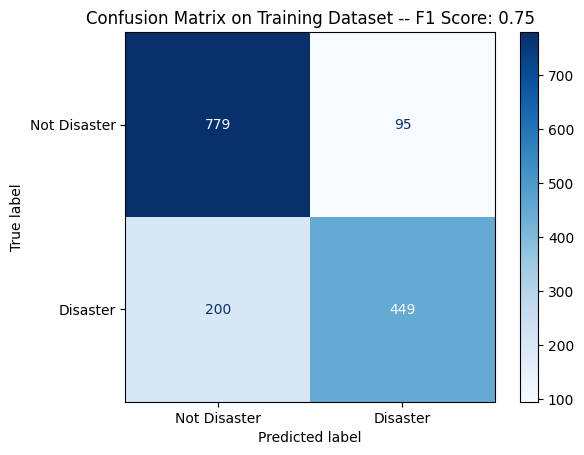

In [29]:
def displayConfusionMatrix(y_true, y_pred, dataset):
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true,
        (y_pred >= 0.5).astype(int),
        display_labels=["Not Disaster","Disaster"],
        cmap=plt.cm.Blues
    )

    tn, fp, fn, tp = confusion_matrix(y_true, (y_pred >= 0.5).astype(int)).ravel()
    f1_score = tp / (tp+((fn+fp)/2))

    disp.ax_.set_title("Confusion Matrix on " + dataset + " Dataset -- F1 Score: " + str(f1_score.round(2)))

y_val_pred = model.predict(X_val)
displayConfusionMatrix(y_val, y_val_pred, "Training")

## Model Prediction

In [98]:
test_df = preprocessing(test_df)
X_test = tokenizer.texts_to_sequences(test_df["text"]) 
X_test = pad_sequences(X_test, maxlen=maxlen)  

In [99]:
# Make predictions
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob >= 0.5).astype(int).flatten()

# Create submission file
submission = pd.DataFrame({
    "id": test_df["id"],  # Ensure the test set has an "id" column
    "target": y_pred
})

# Save to CSV
current_time = datetime.now().strftime('%Y%m%d_%H%M')
submission.to_csv("Prediction/submission_" + current_time + ".csv", index=False)

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
